In [ ]:
import numpy as np
import os
import torch
import cv2
from PIL import Image
from torch.utils.data import Dataset
# mount drive and setup requirements to import other notebooks
!pip install kora -q
from kora import drive
drive.link_nbs()

#used for calculating the accuracy and the mIoU
!git init 2>&1 >> install.log
!git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
!git pull origin master 2>&1 >> install.log

from mit_semseg.utils import accuracy, intersectionAndUnion


From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD


pretrained semantic segmentation models on ADE20K to perform segmentation on own dataset:

Deeplab V3+ (https://pixellib.readthedocs.io/en/latest/image_ade20k.html
)

HRNETV2 (https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb)

If you annotate your own dataset with Segments.ai then look at the documentation from Segments.ai on how to export your labeled images (https://docs.segments.ai/export) to coco format to use our evaluation script.

In [4]:
#Dataloader for the labeled images from Segments.ai in coco format
class CocoLoader(Dataset):
  def __init__(self, root, annFile, transform = None):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform

  def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']
        #img = Image.open(os.path.join(self.root, path)).convert('RGB')
        image = cv2.imread(os.path.join(self.root, path))
        image = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        segmentation_mask = np.ones((image.shape[1], image.shape[0]),dtype=np.uint8)*-1
        for segmentation in target:
          binary_mask = coco.annToMask(segmentation)
          if binary_mask.shape[0] != segmentation_mask.shape[0]:
            segmentation_mask = segmentation_mask.T
            image = image.transpose(1,0,2)
            transposed = True
          segmentation_mask[binary_mask == 1] = segmentation['category_id']
          #segmentation_mask = np.maximum(segmentation_mask,
          #                      coco.annToMask(segmentation)*segmentation['category_id'])
        output_seg = segmentation_mask.astype(np.uint8)
        return image, output_seg, path

  def __len__(self):
        return len(self.ids)

The ```seg_path``` need to be set.

In [ ]:
#gt_path = "/content/drive/MyDrive/Datasets/segments/computervision2021_Indoor/v2.0"
seg_path = "/content/drive/MyDrive/Datasets/segments/computervision2021_Baustelle/v0.2_results_deeplabv3"

```ft_mapping``` corresponds to the mapping of the classes in the ground truth.

```pred_mapping``` corresponds to the mapping of the classes with Deeplab V3+.

```hrpred_mapping``` corresponds to the mapping of the classes with HRNETV2.

In [ ]:
gt_mapping = {-1:-1, # Unkown
              0:0, # Ceiling
              1:1, # Wall
              2:2, # Floor
              3:2, # Wood (Floor)
              4:2, # Granite/marble (Floor)
              5:2, # Tile (Floor)
              6:2, # unkown_floor (Floor)
              7:2,} # Concrete (Floor)
pred_mapping = {-1:-1, # Unkown
                6:0, #ceiling (Ceiling),
                1:1, # wall (Wall)
                4:2, # floor/flooring (Floor)
                29:2} # rug;carpet;carpeting (Floor)
                # Any other value needs to be mapped to -1 (Unkown)
hrpred_mapping = {(120,120,80):0, #ceiling (Ceiling),
                (120,120,120):1, # wall (Wall)
                (80,50,50):2, # floor/flooring (Floor)
                } # rug;carpet;carpeting (Floor)
                # Any other value needs to be mapped to -1 (Unkown)

In [ ]:
def gt_to_common(x):
  return gt_mapping.get(x, -1)

def pred_to_common(x):
  return pred_mapping.get(x, -1)

def hr_pred_to_common(x, mapping):
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  w, h, d = x.shape
  y = np.ones((w,h)) * -1
  for c in mapping.keys():
    y[np.all(x == c,axis=2)] = mapping[c]
  return y

The ```root``` need to be set to your image directory. 

The ```annFile``` need to be set to ```.json``` file from Segments.ai.

In [ ]:
root = "/content/drive/MyDrive/Datasets/segments/computervision2021_Baustelle/v1.0"
annFile = "/content/drive/MyDrive/Datasets/Baustelle-v1.0_coco.json"

loader = torch.utils.data.DataLoader(dataset=CocoLoader(root, annFile),
                                              batch_size=1, 
                                              num_workers=1,
                                              shuffle=False)

ious = []
#for f in os.listdir(seg_path):
for image, seg, name in loader:
  name, ext = name[0].split('.')
  transposed = False
  gt   = np.array(seg)[0]
  #pred = np.array(Image.open(os.path.join(seg_path, name + ".png")))[:,:,0]
  pred = cv2.imread(os.path.join(seg_path, name + ".png"))[:,:,0]
  if transposed:
    gt = np.flip(gt,1)
    pred = pred.T
  #common_pred = hr_pred_to_common(pred, hrpred_mapping)
  common_pred = np.vectorize(pred_to_common)(pred)
  common_gt = np.vectorize(gt_to_common)(gt)
  i,u = intersectionAndUnion(common_pred, common_gt, 3)
  iou = i/u
  print(name, iou)
  #if name == "DSCF1278":
  #  break
  ious.append(iou)

ious = np.array(ious)
img_count = ious.shape[0]

ceiling_nans = np.count_nonzero(np.isnan(ious[:,0]))
wall_nans = np.count_nonzero(np.isnan(ious[:,1]))
floor_nans = np.count_nonzero(np.isnan(ious[:,2]))

ious[np.isnan(ious)] = 0.0

ceiling_sum, wall_sum, floor_sum = np.sum(ious, axis=0)

ceiling_iou =  100.0 * ceiling_sum / (img_count - ceiling_nans)
wall_iou =  100.0 * wall_sum / (img_count - wall_nans) 
floor_iou =  100.0 * floor_sum / (img_count - floor_nans)

average_iou = (ceiling_iou + wall_iou + floor_iou) / 3.0
print("Ceiling mIoU: ", ceiling_iou)
print("Wall mIoU: ", wall_iou)
print("Floor mIoU: ", floor_iou)
print("Average mIoU: ", average_iou)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
DSCF1276 [0.         0.70108059 0.        ]
DSCF1278 [0.01519578 0.18498333 0.22057426]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


DSCF1273 [       nan 0.98280059 0.94639087]
DSCF1287 [       nan 0.80182507 0.92691522]
DSCF1285 [0.80019679 0.90104093 0.98006373]
DSCF1288 [0.95302877 0.88777257 0.81133385]
DSCF1291 [       nan 0.9779686  0.95366415]
DSCF1290 [       nan 0.97808437 0.81536888]
DSCF1293 [       nan 0.7277228  0.21120305]
DSCF1294 [0.         0.90897467 0.46490982]
DSCF1295 [0.28449926 0.82969282 0.63055381]
DSCF1296 [0.09871133 0.31475249 0.60144582]
DSCF1299 [0.88733471 0.96734944 0.97934103]
DSCF1297 [0.         0.19700392 0.1257235 ]
DSCF1300 [0.60468501 0.78983677 0.93921436]
DSCF1303 [       nan 0.99216165 0.96270701]
IMG_2132 [0.         0.41666065 0.0470093 ]
DSCF1304 [0.79953475 0.78810852 0.96468031]
IMG_2133 [0.         0.40231495 0.        ]
DSCF1307 [0.89391    0.93144296 0.93533764]
DSCF1309 [0.94623323 0.98643519 0.92423298]
DSCF1310 [0.96907596 0.95808039 0.93627242]
Ceiling mIoU:  45.32753492493375
Wall mIoU:  75.57315123318288
Floor mIoU:  65.3497364034332
Average mIoU:  62.083474187

(3264, 1836, 3)


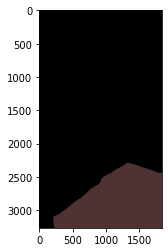

In [ ]:
#image = Image.open("/content/drive/MyDrive/Datasets/segments/computervision2021_Baustelle/v0.2/DSCF1276.jpg")
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
import cv2
image = cv2.imread("/content/drive/MyDrive/Datasets/segments/computervision2021_Indoor/v1.1_results_hrnet/ACrG0-GtAAwx.png")
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image[np.all(image != (80,50,50),axis=2)] = (0,0,0)
imshow(image)

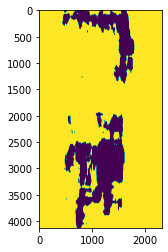

In [ ]:
imshow(common_pred)

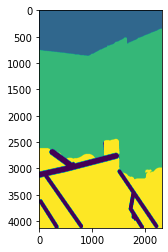

In [ ]:
imshow(common_gt)

In [ ]:
ious = a.copy()
img_count = ious.shape[0]

ceiling_nans = np.count_nonzero(np.isnan(ious[:,0]))
wall_nans = np.count_nonzero(np.isnan(ious[:,1]))
floor_nans = np.count_nonzero(np.isnan(ious[:,2]))

ious[np.isnan(ious)] = 0.0

ceiling_sum, wall_sum, floor_sum = np.sum(ious, axis=0)

ceiling_iou =  100.0 * ceiling_sum / (img_count - ceiling_nans)
wall_iou =  100.0 * wall_sum / (img_count - wall_nans) 
floor_iou =  100.0 * floor_sum / (img_count - floor_nans)

average_iou = (ceiling_iou + wall_iou + floor_iou) / 3.0
print("Ceiling mIoU: ", ceiling_iou)
print("Wall mIoU: ", wall_iou)
print("Floor mIoU: ", floor_iou)
print("Average mIoU: ", average_iou)

Ceiling mIoU:  62.627112892482636
Wall mIoU:  81.7499708310193
Floor mIoU:  88.32411071805382
Average mIoU:  77.56706481385191


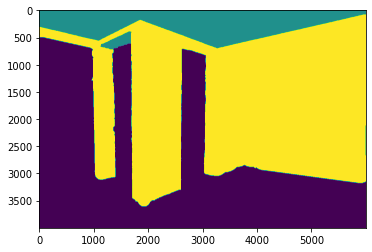

In [ ]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
imshow(common_gt[0])

In [ ]:
!pip install segments-ai -q
from segments import SegmentsDataset
from segments.utils import export_dataset

# Initialize a SegmentsDataset from the release file
release_file = '/content/drive/MyDrive/Baustelle-v1.0.json'
segments_dir = '/content/drive/MyDrive/Datasets/segments'
dataset = SegmentsDataset(release_file, 
                          filter_by=['labeled', 'reviewed'],
                          segments_dir=segments_dir)

# Export to COCO format
export_dataset(dataset, 'coco')

Initializing dataset. This may take a few seconds...


100%|██████████| 22/22 [00:24<00:00,  1.13s/it]


Initialized dataset with 22 images.


100%|██████████| 22/22 [00:38<00:00,  1.77s/it]

Exported to Baustelle-v1.0_coco.json.


('Baustelle-v1.0_coco.json',
 '/content/drive/MyDrive/Datasets/segments/computervision2021_Baustelle/v1.0')